In [1]:
!git clone https://github.com/taoxugit/AttnGAN.git
%cd AttnGAN

Cloning into 'AttnGAN'...
remote: Enumerating objects: 291, done.
remote: Total 291 (delta 0), reused 0 (delta 0), pack-reused 291
Receiving objects: 100% (291/291), 36.75 MiB | 40.55 MiB/s, done.
Resolving deltas: 100% (167/167), done.
/kaggle/working/AttnGAN


In [2]:
# %%capture
# !rm -rf data/*
# !wget https://www.dropbox.com/s/pfb3ax1w8yfn40x/coco.zip -P data/
# !unzip data/coco.zip -d data/
# !unzip data/coco/val2014-text.zip -d data/coco/
# !mv data/coco/val2014 data/coco/text
# !ls -l --block-size=M data/coco/

Это долго! Происходит перенос датасета в папку репозитория. Можно и без этого, но мне нужно, чтобы было понятно, где какая папка лежит и сколько памяти реально занимает все это дело

In [3]:
!mkdir -p /kaggle/working/AttnGAN/data/books/images && cp -r /kaggle/input/bookcovers/images/images /kaggle/working/AttnGAN/data/books/
!mkdir -p /kaggle/working/AttnGAN/data/books/text/ && cp -r /kaggle/input/bookcovers/text/text /kaggle/working/AttnGAN/data/books/

In [4]:
!mkdir -p /kaggle/working/AttnGAN/data/books/test/ && cp -r /kaggle/input/bookcovers/test/test/ /kaggle/working/AttnGAN/data/books/
!mkdir -p /kaggle/working/AttnGAN/data/books/train/ && cp -r /kaggle/input/bookcovers/train/train/ /kaggle/working/AttnGAN/data/books/

Подгружаем созданные заранее .yml файлы и меняем конфигурации под наши данные

In [5]:
!cp /kaggle/input/attngan/books_yml/books_yml/books.yml /kaggle/working/AttnGAN/code/cfg/DAMSM/
!cp /kaggle/input/attngan/books_yml/books_yml/books_attn2.yml /kaggle/working/AttnGAN/code/cfg/

In [6]:
!sed -i "s/DATASET_NAME = 'birds'/DATASET_NAME = 'books'/g" /kaggle/working/AttnGAN/code/miscc/config.py
!sed -i "s#DATA_DIR = ''#DATA_DIR = '../data/books'#g" /kaggle/working/AttnGAN/code/miscc/config.py

!sed -i "s/CAPTIONS_PER_IMAGE: 10/CAPTIONS_PER_IMAGE: 4/g" /kaggle/working/AttnGAN/code/cfg/books_attn2.yml
!sed -i "s/CAPTIONS_PER_IMAGE: 10/CAPTIONS_PER_IMAGE: 4/g" /kaggle/working/AttnGAN/code/cfg/DAMSM/books.yml

!sed -i "s/NET_E: '..\/DAMSMencoders\/coco\/text_encoder100.pth'/NET_E: ''/g" /kaggle/working/AttnGAN/code/cfg/DAMSM/books.yml
!sed -i "s/SNAPSHOT_INTERVAL: 50/SNAPSHOT_INTERVAL: 5/g" /kaggle/working/AttnGAN/code/cfg/DAMSM/books.yml

!sed -i "s/SNAPSHOT_INTERVAL: 50/SNAPSHOT_INTERVAL: 5/g" /kaggle/working/AttnGAN/code/cfg/books_attn2.yml
!sed -i "s/MAX_EPOCH: 100/MAX_EPOCH: 50/g" /kaggle/working/AttnGAN/code/cfg/books_attn2.yml

In [7]:
!cp -r /kaggle/input/attngan/coco_AttnGAN2.pth /kaggle/working/AttnGAN/models
!cp -r /kaggle/input/attngan/coco/coco /kaggle/working/AttnGAN/DAMSMencoders

In [8]:
!mkdir -p /kaggle/working/AttnGAN/DAMSMencoders/books/ && cp -r /kaggle/working/AttnGAN/DAMSMencoders/coco/* /kaggle/working/AttnGAN/DAMSMencoders/books/

# Чиним и меняем авторский AttnGAN

In [9]:
%cd code

/kaggle/working/AttnGAN/code


In [10]:
!sed -i 's/yaml.load(/yaml.safe_load(/g' /kaggle/working/AttnGAN/code/miscc/config.py

In [11]:
!sed -i 's/iteritems/items/g' /kaggle/working/AttnGAN/code/miscc/config.py

In [12]:
!sed -i "s/\.has_key(k)/ in k/g" /kaggle/working/AttnGAN/code/miscc/config.py
!sed -i "s/if not b in k:/if not k in b:/g" /kaggle/working/AttnGAN/code/miscc/config.py

In [13]:
!sed -i 's/transforms.Scale(/transforms.Resize(/g' /kaggle/working/AttnGAN/code/main.py

In [14]:
!sed -i 's/torch\.cuda\.set_device(\(.*\))/torch.cuda.device(\1)/g' /kaggle/working/AttnGAN/code/trainer.py

In [15]:
!sed -i "s/\.decode('utf8')//g" /kaggle/working/AttnGAN/code/main.py

In [16]:
!echo ''>/kaggle/working/AttnGAN/code/miscc/utils.py

In [17]:
with open('/kaggle/working/AttnGAN/code/miscc/utils.py', 'w') as f:
    f.write('''
import os
import errno
import numpy as np
from torch.nn import init

import torch
import torch.nn as nn

from PIL import Image, ImageDraw, ImageFont
from copy import deepcopy
import skimage.transform

from miscc.config import cfg


# For visualization ################################################
COLOR_DIC = {0: [128, 64, 128],  1: [244, 35, 232],
             2: [70, 70, 70],  3: [102, 102, 156],
             4: [190, 153, 153], 5: [153, 153, 153],
             6: [250, 170, 30], 7: [220, 220, 0],
             8: [107, 142, 35], 9: [152, 251, 152],
             10: [70, 130, 180], 11: [220, 20, 60],
             12: [255, 0, 0],  13: [0, 0, 142],
             14: [119, 11, 32], 15: [0, 60, 100],
             16: [0, 80, 100], 17: [0, 0, 230],
             18: [0,  0, 70],  19: [0, 0,  0]}
FONT_MAX = 50


def drawCaption(convas, captions, ixtoword, vis_size, off1=2, off2=2):
    num = captions.size(0)
    img_txt = Image.fromarray(convas)
    # get a font
    # fnt = None  # ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 50)
    # fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 50)
    fnt = ImageFont.load_default()
    # get a drawing context
    d = ImageDraw.Draw(img_txt)
    sentence_list = []
    for i in range(num):
        cap = captions[i].data.cpu().numpy()
        sentence = []
        for j in range(len(cap)):
            if cap[j] == 0:
                break
            word = ixtoword[cap[j]].encode('ascii', 'ignore').decode('ascii')
            d.text(((j + off1) * (vis_size + off2), i * FONT_MAX), '%d:%s' % (j, word[:6]),
                   font=fnt, fill=(255, 255, 255, 255))
            sentence.append(word)
        sentence_list.append(sentence)
    return img_txt, sentence_list


def build_super_images(real_imgs, captions, ixtoword,
                       attn_maps, att_sze, lr_imgs=None,
                       batch_size=cfg.TRAIN.BATCH_SIZE,
                       max_word_num=cfg.TEXT.WORDS_NUM):
    nvis = 8
    real_imgs = real_imgs[:nvis]
    if lr_imgs is not None:
        lr_imgs = lr_imgs[:nvis]
    if att_sze == 17:
        vis_size = att_sze * 16
    else:
        vis_size = real_imgs.size(2)

    text_convas = \
        np.ones([batch_size * FONT_MAX,
                 (max_word_num + 2) * (vis_size + 2), 3],
                dtype=np.uint8)

    for i in range(max_word_num):
        istart = (i + 2) * (vis_size + 2)
        iend = (i + 3) * (vis_size + 2)
        text_convas[:, istart:iend, :] = COLOR_DIC[i]

    real_imgs = \
        nn.Upsample(size=(vis_size, vis_size), mode='bilinear')(real_imgs)
    # [-1, 1] --> [0, 1]
    real_imgs.add_(1).div_(2).mul_(255)
    real_imgs = real_imgs.data.numpy()
    # b x c x h x w --> b x h x w x c
    real_imgs = np.transpose(real_imgs, (0, 2, 3, 1))
    pad_sze = real_imgs.shape
    middle_pad = np.zeros([pad_sze[2], 2, 3])
    post_pad = np.zeros([pad_sze[1], pad_sze[2], 3])
    if lr_imgs is not None:
        lr_imgs = \
            nn.Upsample(size=(vis_size, vis_size), mode='bilinear')(lr_imgs)
        # [-1, 1] --> [0, 1]
        lr_imgs.add_(1).div_(2).mul_(255)
        lr_imgs = lr_imgs.data.numpy()
        # b x c x h x w --> b x h x w x c
        lr_imgs = np.transpose(lr_imgs, (0, 2, 3, 1))

    # batch x seq_len x 17 x 17 --> batch x 1 x 17 x 17
    seq_len = max_word_num
    img_set = []
    num = nvis  # len(attn_maps)

    text_map, sentences = \
        drawCaption(text_convas, captions, ixtoword, vis_size)
    text_map = np.asarray(text_map).astype(np.uint8)

    bUpdate = 1
    for i in range(num):
        attn = attn_maps[i].cpu().view(1, -1, att_sze, att_sze)
        # --> 1 x 1 x 17 x 17
        attn_max = attn.max(dim=1, keepdim=True)
        attn = torch.cat([attn_max[0], attn], 1)
        #
        attn = attn.view(-1, 1, att_sze, att_sze)
        attn = attn.repeat(1, 3, 1, 1).data.numpy()
        # n x c x h x w --> n x h x w x c
        attn = np.transpose(attn, (0, 2, 3, 1))
        num_attn = attn.shape[0]
        #
        img = real_imgs[i]
        if lr_imgs is None:
            lrI = img
        else:
            lrI = lr_imgs[i]
        row = [lrI, middle_pad]
        row_merge = [img, middle_pad]
        row_beforeNorm = []
        minVglobal, maxVglobal = 1, 0
        for j in range(num_attn):
            one_map = attn[j]
            if (vis_size // att_sze) > 1:
                one_map = \
                    skimage.transform.pyramid_expand(one_map, sigma=20,
                                                     upscale=vis_size // att_sze)
            row_beforeNorm.append(one_map)
            minV = one_map.min()
            maxV = one_map.max()
            if minVglobal > minV:
                minVglobal = minV
            if maxVglobal < maxV:
                maxVglobal = maxV
        for j in range(seq_len + 1):
            if j < num_attn:
                one_map = row_beforeNorm[j]
                one_map = (one_map - minVglobal) / (maxVglobal - minVglobal)
                one_map *= 255
                #
                PIL_im = Image.fromarray(np.uint8(img))
                one_map_rgb = one_map[..., :3]
                PIL_att = Image.fromarray(np.uint8(one_map_rgb))
                merged = \
                    Image.new('RGBA', (vis_size, vis_size), (0, 0, 0, 0))
                mask = Image.new('L', (vis_size, vis_size), (210))
                merged.paste(PIL_im, (0, 0))
                merged.paste(PIL_att, (0, 0), mask)
                merged = np.array(merged)[:, :, :3]
            else:
                one_map = post_pad
                one_map_rgb = one_map[..., :3]
                merged = post_pad
            row.append(one_map_rgb)
            row.append(middle_pad)
            #
            row_merge.append(merged)
            row_merge.append(middle_pad)
        row = np.concatenate(row, 1)
        row_merge = np.concatenate(row_merge, 1)
        txt = text_map[i * FONT_MAX: (i + 1) * FONT_MAX]
        if txt.shape[1] != row.shape[1]:
            print('txt', txt.shape, 'row', row.shape)
            bUpdate = 0
            break
        row = np.concatenate([txt, row, row_merge], 0)
        img_set.append(row)
    if bUpdate:
        img_set = np.concatenate(img_set, 0)
        img_set = img_set.astype(np.uint8)
        return img_set, sentences
    else:
        return None


def build_super_images2(real_imgs, captions, cap_lens, ixtoword,
                        attn_maps, att_sze, vis_size=256, topK=5):
    batch_size = real_imgs.size(0)
    max_word_num = np.max(cap_lens)
    text_convas = np.ones([batch_size * FONT_MAX,
                           max_word_num * (vis_size + 2), 3],
                          dtype=np.uint8)

    real_imgs = \
        nn.Upsample(size=(vis_size, vis_size), mode='bilinear')(real_imgs)
    # [-1, 1] --> [0, 1]
    real_imgs.add_(1).div_(2).mul_(255)
    real_imgs = real_imgs.data.numpy()
    # b x c x h x w --> b x h x w x c
    real_imgs = np.transpose(real_imgs, (0, 2, 3, 1))
    pad_sze = real_imgs.shape
    middle_pad = np.zeros([pad_sze[2], 2, 3])

    # batch x seq_len x 17 x 17 --> batch x 1 x 17 x 17
    img_set = []
    num = len(attn_maps)

    text_map, sentences = \
        drawCaption(text_convas, captions, ixtoword, vis_size, off1=0)
    text_map = np.asarray(text_map).astype(np.uint8)

    bUpdate = 1
    for i in range(num):
        attn = attn_maps[i].cpu().view(1, -1, att_sze, att_sze)
        #
        attn = attn.view(-1, 1, att_sze, att_sze)
        attn = attn.repeat(1, 3, 1, 1).data.numpy()
        # n x c x h x w --> n x h x w x c
        attn = np.transpose(attn, (0, 2, 3, 1))
        num_attn = cap_lens[i]
        thresh = 2./float(num_attn)
        #
        img = real_imgs[i]
        row = []
        row_merge = []
        row_txt = []
        row_beforeNorm = []
        conf_score = []
        for j in range(num_attn):
            one_map = attn[j]
            mask0 = one_map > (2. * thresh)
            conf_score.append(np.sum(one_map * mask0))
            mask = one_map > thresh
            one_map = one_map * mask
            if (vis_size // att_sze) > 1:
                one_map = \
                    skimage.transform.pyramid_expand(one_map, sigma=20,
                                                     upscale=vis_size // att_sze)
            minV = one_map.min()
            maxV = one_map.max()
            one_map = (one_map - minV) / (maxV - minV)
            row_beforeNorm.append(one_map)
        sorted_indices = np.argsort(conf_score)[::-1]

        for j in range(num_attn):
            one_map = row_beforeNorm[j]
            one_map *= 255
            #
            PIL_im = Image.fromarray(np.uint8(img))
            one_map_rgb = one_map[..., :3]
            PIL_att = Image.fromarray(np.uint8(one_map_rgb))
#             PIL_att = Image.fromarray(np.uint8(one_map))
            merged = \
                Image.new('RGBA', (vis_size, vis_size), (0, 0, 0, 0))
            mask = Image.new('L', (vis_size, vis_size), (180))  # (210)
            merged.paste(PIL_im, (0, 0))
            merged.paste(PIL_att, (0, 0), mask)
            merged = np.array(merged)[:, :, :3]

#             row.append(np.concatenate([one_map, middle_pad], 1))
            height, width, _ = one_map.shape
            new_one_map = np.zeros((height, width, 3))
            new_one_map[:, :, :3] = one_map[:, :, :3]
            row.append(np.concatenate([new_one_map, middle_pad], 1))

            #
            row_merge.append(np.concatenate([merged, middle_pad], 1))
            #
            txt = text_map[i * FONT_MAX:(i + 1) * FONT_MAX,
                           j * (vis_size + 2):(j + 1) * (vis_size + 2), :]
            row_txt.append(txt)
        # reorder
        row_new = []
        row_merge_new = []
        txt_new = []
        for j in range(num_attn):
            idx = sorted_indices[j]
            row_new.append(row[idx])
            row_merge_new.append(row_merge[idx])
            txt_new.append(row_txt[idx])
        row = np.concatenate(row_new[:topK], 1)
        row_merge = np.concatenate(row_merge_new[:topK], 1)
        txt = np.concatenate(txt_new[:topK], 1)
        if txt.shape[1] != row.shape[1]:
            print('Warnings: txt', txt.shape, 'row', row.shape,
                  'row_merge_new', row_merge_new.shape)
            bUpdate = 0
            break
        row = np.concatenate([txt, row_merge], 0)
        img_set.append(row)
    if bUpdate:
        img_set = np.concatenate(img_set, 0)
        img_set = img_set.astype(np.uint8)
        return img_set, sentences
    else:
        return None


####################################################################
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.orthogonal(m.weight.data, 1.0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        nn.init.orthogonal(m.weight.data, 1.0)
        if m.bias is not None:
            m.bias.data.fill_(0.0)


def load_params(model, new_param):
    for p, new_p in zip(model.parameters(), new_param):
        p.data.copy_(new_p)


def copy_G_params(model):
    flatten = deepcopy(list(p.data for p in model.parameters()))
    return flatten


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
''')

In [18]:
!echo '' > /kaggle/working/AttnGAN/code/trainer.py

In [19]:
with open('/kaggle/working/AttnGAN/code/trainer.py', 'w') as f:
    f.write('''
from __future__ import print_function
from six.moves import range

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

from PIL import Image

from miscc.config import cfg
from miscc.utils import mkdir_p
from miscc.utils import build_super_images, build_super_images2
from miscc.utils import weights_init, load_params, copy_G_params
from model import G_DCGAN, G_NET
from datasets import prepare_data
from model import RNN_ENCODER, CNN_ENCODER

from miscc.losses import words_loss
from miscc.losses import discriminator_loss, generator_loss, KL_loss
import os
import time
import numpy as np
import sys

# ################# Text to image task############################ #


class condGANTrainer(object):
    def __init__(self, output_dir, data_loader, n_words, ixtoword):
        if cfg.TRAIN.FLAG:
            self.model_dir = os.path.join(output_dir, 'Model')
            self.image_dir = os.path.join(output_dir, 'Image')
            mkdir_p(self.model_dir)
            mkdir_p(self.image_dir)

        torch.cuda.device(cfg.GPU_ID)
        cudnn.benchmark = True

        self.batch_size = cfg.TRAIN.BATCH_SIZE
        self.max_epoch = cfg.TRAIN.MAX_EPOCH
        self.snapshot_interval = cfg.TRAIN.SNAPSHOT_INTERVAL

        self.n_words = n_words
        self.ixtoword = ixtoword
        self.data_loader = data_loader
        self.num_batches = len(self.data_loader)

    def build_models(self):
        # ###################encoders######################################## #
        if cfg.TRAIN.NET_E == '':
            print('Error: no pretrained text-image encoders')
            return

        image_encoder = CNN_ENCODER(cfg.TEXT.EMBEDDING_DIM)
        img_encoder_path = cfg.TRAIN.NET_E.replace(
            'text_encoder', 'image_encoder')
        state_dict = \
            torch.load(img_encoder_path,
                       map_location=lambda storage, loc: storage)
        image_encoder.load_state_dict(state_dict)
        for p in image_encoder.parameters():
            p.requires_grad = False
        print('Load image encoder from:', img_encoder_path)
        image_encoder.eval()

        text_encoder = \
            RNN_ENCODER(self.n_words, nhidden=cfg.TEXT.EMBEDDING_DIM)
        state_dict = \
            torch.load(cfg.TRAIN.NET_E,
                       map_location=lambda storage, loc: storage)
        text_encoder.load_state_dict(state_dict)
        for p in text_encoder.parameters():
            p.requires_grad = False
        print('Load text encoder from:', cfg.TRAIN.NET_E)
        text_encoder.eval()

        # #######################generator and discriminators############## #
        netsD = []
        if cfg.GAN.B_DCGAN:
            if cfg.TREE.BRANCH_NUM == 1:
                from model import D_NET64 as D_NET
            elif cfg.TREE.BRANCH_NUM == 2:
                from model import D_NET128 as D_NET
            else:  # cfg.TREE.BRANCH_NUM == 3:
                from model import D_NET256 as D_NET
            # TODO: elif cfg.TREE.BRANCH_NUM > 3:
            netG = G_DCGAN()
            netsD = [D_NET(b_jcu=False)]
        else:
            from model import D_NET64, D_NET128, D_NET256
            netG = G_NET()
            if cfg.TREE.BRANCH_NUM > 0:
                netsD.append(D_NET64())
            if cfg.TREE.BRANCH_NUM > 1:
                netsD.append(D_NET128())
            if cfg.TREE.BRANCH_NUM > 2:
                netsD.append(D_NET256())
            # TODO: if cfg.TREE.BRANCH_NUM > 3:
        netG.apply(weights_init)
        # print(netG)
        for i in range(len(netsD)):
            netsD[i].apply(weights_init)
            # print(netsD[i])
        print('# of netsD', len(netsD))
        #
        epoch = 0
        if cfg.TRAIN.NET_G != '':
            state_dict = \
                torch.load(cfg.TRAIN.NET_G,
                           map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load G from: ', cfg.TRAIN.NET_G)
            istart = cfg.TRAIN.NET_G.rfind('_') + 1
            iend = cfg.TRAIN.NET_G.rfind('.')
            epoch = cfg.TRAIN.NET_G[istart:iend]
            epoch = int(epoch) + 1
            if cfg.TRAIN.B_NET_D:
                Gname = cfg.TRAIN.NET_G
                for i in range(len(netsD)):
                    s_tmp = Gname[:Gname.rfind('/')]
                    Dname = '%s/netD%d.pth' % (s_tmp, i)
                    print('Load D from: ', Dname)
                    state_dict = \
                        torch.load(
                            Dname, map_location=lambda storage, loc: storage)
                    netsD[i].load_state_dict(state_dict)
        # ########################################################### #
        if cfg.CUDA:
            text_encoder = text_encoder.cuda()
            image_encoder = image_encoder.cuda()
            netG.cuda()
            for i in range(len(netsD)):
                netsD[i].cuda()
        return [text_encoder, image_encoder, netG, netsD, epoch]

    def define_optimizers(self, netG, netsD):
        optimizersD = []
        num_Ds = len(netsD)
        for i in range(num_Ds):
            opt = optim.Adam(netsD[i].parameters(),
                             lr=cfg.TRAIN.DISCRIMINATOR_LR,
                             betas=(0.5, 0.999))
            optimizersD.append(opt)

        optimizerG = optim.Adam(netG.parameters(),
                                lr=cfg.TRAIN.GENERATOR_LR,
                                betas=(0.5, 0.999))

        return optimizerG, optimizersD

    def prepare_labels(self):
        batch_size = self.batch_size
        real_labels = Variable(torch.FloatTensor(batch_size).fill_(1))
        fake_labels = Variable(torch.FloatTensor(batch_size).fill_(0))
        match_labels = Variable(torch.LongTensor(range(batch_size)))
        if cfg.CUDA:
            real_labels = real_labels.cuda()
            fake_labels = fake_labels.cuda()
            match_labels = match_labels.cuda()

        return real_labels, fake_labels, match_labels

    def save_model(self, netG, avg_param_G, netsD, epoch):
        backup_para = copy_G_params(netG)
        load_params(netG, avg_param_G)
        torch.save(netG.state_dict(),
                   '%s/netG_epoch_%d.pth' % (self.model_dir, epoch))
        load_params(netG, backup_para)
        #
        for i in range(len(netsD)):
            netD = netsD[i]
            torch.save(netD.state_dict(),
                       '%s/netD%d.pth' % (self.model_dir, i))
        print('Save G/Ds models.')

    def set_requires_grad_value(self, models_list, brequires):
        for i in range(len(models_list)):
            for p in models_list[i].parameters():
                p.requires_grad = brequires

    def save_img_results(self, netG, noise, sent_emb, words_embs, mask,
                         image_encoder, captions, cap_lens,
                         gen_iterations, name='current'):
        # Save images
        fake_imgs, attention_maps, _, _ = netG(
            noise, sent_emb, words_embs, mask)
        for i in range(len(attention_maps)):
            if len(fake_imgs) > 1:
                img = fake_imgs[i + 1].detach().cpu()
                lr_img = fake_imgs[i].detach().cpu()
            else:
                img = fake_imgs[0].detach().cpu()
                lr_img = None
            attn_maps = attention_maps[i]
            att_sze = attn_maps.size(2)

            img_set, _ = \
                build_super_images(img, captions, self.ixtoword,
                                   attn_maps, att_sze, lr_imgs=lr_img)
            if img_set is not None:
                im = Image.fromarray(img_set)
                fullpath = '%s/G_%s_%d_%d.png'\
                    % (self.image_dir, name, gen_iterations, i)
                im.save(fullpath)

        # for i in range(len(netsD)):
        i = -1
        img = fake_imgs[i].detach()
        region_features, _ = image_encoder(img)
        att_sze = region_features.size(2)
        _, _, att_maps = words_loss(region_features.detach(),
                                    words_embs.detach(),
                                    None, cap_lens,
                                    None, self.batch_size)
                                    
        img_set, _ = \
            build_super_images(fake_imgs[i].detach().cpu(),
                               captions, self.ixtoword, att_maps, att_sze)
        if img_set is not None:
            im = Image.fromarray(img_set)
            fullpath = '%s/D_%s_%d.png'\
                % (self.image_dir, name, gen_iterations)
            im.save(fullpath)

    def train(self):
        text_encoder, image_encoder, netG, netsD, start_epoch = self.build_models()
        avg_param_G = copy_G_params(netG)
        optimizerG, optimizersD = self.define_optimizers(netG, netsD)
        real_labels, fake_labels, match_labels = self.prepare_labels()

        batch_size = self.batch_size
        nz = cfg.GAN.Z_DIM
        noise = Variable(torch.FloatTensor(batch_size, nz))
        fixed_noise = Variable(torch.FloatTensor(batch_size, nz).normal_(0, 1))
        if cfg.CUDA:
            noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

        gen_iterations = 0
        # gen_iterations = start_epoch * self.num_batches
        for epoch in range(start_epoch, self.max_epoch):
            start_t = time.time()

            data_iter = iter(self.data_loader)
            step = 0
            while step < self.num_batches:
                # reset requires_grad to be trainable for all Ds
                # self.set_requires_grad_value(netsD, True)

                ######################################################
                # (1) Prepare training data and Compute text embeddings
                ######################################################
                data = data_iter.next()
                imgs, captions, cap_lens, class_ids, keys = prepare_data(data)

                hidden = text_encoder.init_hidden(batch_size)
                # words_embs: batch_size x nef x seq_len
                # sent_emb: batch_size x nef
                words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
                words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
                mask = (captions == 0)
                num_words = words_embs.size(2)
                if mask.size(1) > num_words:
                    mask = mask[:, :num_words]

                #######################################################
                # (2) Generate fake images
                ######################################################
                noise.data.normal_(0, 1)
                fake_imgs, _, mu, logvar = netG(
                    noise, sent_emb, words_embs, mask)

                #######################################################
                # (3) Update D network
                ######################################################
                errD_total = 0
                D_logs = ''
                for i in range(len(netsD)):
                    netsD[i].zero_grad()
                    errD = discriminator_loss(netsD[i], imgs[i], fake_imgs[i],
                                              sent_emb, real_labels, fake_labels)
                    # backward and update parameters
                    errD.backward()
                    optimizersD[i].step()
                    errD_total += errD
                    D_logs += 'errD%d: %.2f ' % (i, errD.data[0])

                #######################################################
                # (4) Update G network: maximize log(D(G(z)))
                ######################################################
                # compute total loss for training G
                step += 1
                gen_iterations += 1

                # do not need to compute gradient for Ds
                # self.set_requires_grad_value(netsD, False)
                netG.zero_grad()
                errG_total, G_logs = \
                    generator_loss(netsD, image_encoder, fake_imgs, real_labels,
                                   words_embs, sent_emb, match_labels, cap_lens, class_ids)
                kl_loss = KL_loss(mu, logvar)
                errG_total += kl_loss
                G_logs += 'kl_loss: %.2f ' % kl_loss.data[0]
                # backward and update parameters
                errG_total.backward()
                optimizerG.step()
                for p, avg_p in zip(netG.parameters(), avg_param_G):
                    avg_p.mul_(0.999).add_(0.001, p.data)

                # save images
                if gen_iterations % 1000 == 0:
                    backup_para = copy_G_params(netG)
                    load_params(netG, avg_param_G)
                    self.save_img_results(netG, fixed_noise, sent_emb,
                                          words_embs, mask, image_encoder,
                                          captions, cap_lens, epoch, name='average')
                    load_params(netG, backup_para)
                    #
                    # self.save_img_results(netG, fixed_noise, sent_emb,
                    #                       words_embs, mask, image_encoder,
                    #                       captions, cap_lens,
                    #                       epoch, name='current')
            end_t = time.time()

            #print("[%d/%d][%d]\n
             #     Loss_D: %.2f Loss_G: %.2f Time: %.2fs"
              #    % (epoch, self.max_epoch, self.num_batches,
               #      errD_total.data[0], errG_total.data[0],
                #     end_t - start_t))

            if epoch % cfg.TRAIN.SNAPSHOT_INTERVAL == 0:  # and epoch != 0:
                self.save_model(netG, avg_param_G, netsD, epoch)

        self.save_model(netG, avg_param_G, netsD, self.max_epoch)

    def save_singleimages(self, images, filenames, save_dir,
                          split_dir, sentenceID=0):
        for i in range(images.size(0)):
            s_tmp = '%s/single_samples/%s/%s' %\
                (save_dir, split_dir, filenames[i])
            folder = s_tmp[:s_tmp.rfind('/')]
            if not os.path.isdir(folder):
                print('Make a new folder: ', folder)
                mkdir_p(folder)

            fullpath = '%s_%d.jpg' % (s_tmp, sentenceID)
            # range from [-1, 1] to [0, 1]
            # img = (images[i] + 1.0) / 2
            img = images[i].add(1).div(2).mul(255).clamp(0, 255).byte()
            # range from [0, 1] to [0, 255]
            ndarr = img.permute(1, 2, 0).data.cpu().numpy()
                    
            im = Image.fromarray(ndarr)
            im.save(fullpath)

    def sampling(self, split_dir):
        if cfg.TRAIN.NET_G == '':
            print('Error: the path for morels is not found!')
        else:
            if split_dir == 'test':
                split_dir = 'valid'
            # Build and load the generator
            if cfg.GAN.B_DCGAN:
                netG = G_DCGAN()
            else:
                netG = G_NET()
            netG.apply(weights_init)
            netG.cuda()
            netG.eval()
            #
            text_encoder = RNN_ENCODER(
                self.n_words, nhidden=cfg.TEXT.EMBEDDING_DIM)
            state_dict = \
                torch.load(cfg.TRAIN.NET_E,
                           map_location=lambda storage, loc: storage)
            text_encoder.load_state_dict(state_dict)
            print('Load text encoder from:', cfg.TRAIN.NET_E)
            text_encoder = text_encoder.cuda()
            text_encoder.eval()

            batch_size = self.batch_size
            nz = cfg.GAN.Z_DIM
            noise = Variable(torch.FloatTensor(batch_size, nz), volatile=True)
            noise = noise.cuda()

            model_dir = cfg.TRAIN.NET_G
            state_dict = \
                torch.load(
                    model_dir, map_location=lambda storage, loc: storage)
            # state_dict = torch.load(cfg.TRAIN.NET_G)
            netG.load_state_dict(state_dict)
            print('Load G from: ', model_dir)

            # the path to save generated images
            s_tmp = model_dir[:model_dir.rfind('.pth')]
            save_dir = '%s' % ("output", split_dir)
            mkdir_p(save_dir)

            cnt = 0

            for _ in range(1):  # (cfg.TEXT.CAPTIONS_PER_IMAGE):
                for step, data in enumerate(self.data_loader, 0):
                    cnt += batch_size
                    if step % 100 == 0:
                        print('step: ', step)
                    # if step > 50:
                    #     break

                    imgs, captions, cap_lens, class_ids, keys = prepare_data(
                        data)

                    hidden = text_encoder.init_hidden(batch_size)
                    # words_embs: batch_size x nef x seq_len
                    # sent_emb: batch_size x nef
                    words_embs, sent_emb = text_encoder(
                        captions, cap_lens, hidden)
                    words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
                    mask = (captions == 0)
                    num_words = words_embs.size(2)
                    if mask.size(1) > num_words:
                        mask = mask[:, :num_words]

                    #######################################################
                    # (2) Generate fake images
                    ######################################################
                    noise.data.normal_(0, 1)
                    fake_imgs, _, _, _ = netG(
                        noise, sent_emb, words_embs, mask)
                    for j in range(batch_size):
                        s_tmp = '%s/single/%s' % (save_dir, keys[j])
                        folder = s_tmp[:s_tmp.rfind('/')]
                        if not os.path.isdir(folder):
                            print('Make a new folder: ', folder)
                            mkdir_p(folder)
                        k = -1
                        # for k in range(len(fake_imgs)):
                        im = fake_imgs[k][j].data.cpu().numpy()
                        # [-1, 1] --> [0, 255]
                        im = (im + 1.0) * 127.5
                        im = im.astype(np.uint8)
                        im = np.transpose(im, (1, 2, 0))
                        im = Image.fromarray(im)
                        fullpath = '%s_s%d.png' % (s_tmp, k)
                        im.save(fullpath)

    def gen_example(self, output_dir, data_dic):
        if cfg.TRAIN.NET_G == '':
            print('Error: the path for models is not found!')
        else:
            # Build and load the generator
            text_encoder = \
                RNN_ENCODER(self.n_words, nhidden=cfg.TEXT.EMBEDDING_DIM)
            print(self.n_words)
            state_dict = \
                torch.load(cfg.TRAIN.NET_E,
                           map_location=lambda storage, loc: storage)
            text_encoder.load_state_dict(state_dict)
            print('Load text encoder from:', cfg.TRAIN.NET_E)
            text_encoder = text_encoder.cuda()
            text_encoder.eval()

            # the path to save generated images
            if cfg.GAN.B_DCGAN:
                netG = G_DCGAN()
            else:
                netG = G_NET()
            s_tmp = cfg.TRAIN.NET_G[:cfg.TRAIN.NET_G.rfind('.pth')]
            model_dir = cfg.TRAIN.NET_G
            state_dict = \
                torch.load(
                    model_dir, map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load G from: ', model_dir)
            netG.cuda()
            netG.eval()
            for key in data_dic:
                save_dir = '%s' % (output_dir)
                mkdir_p(save_dir)
                captions, cap_lens, sorted_indices = data_dic[key]

                batch_size = captions.shape[0]
                nz = cfg.GAN.Z_DIM
                captions = Variable(torch.from_numpy(captions), volatile=True)
                cap_lens = Variable(torch.from_numpy(cap_lens), volatile=True)

                captions = captions.cuda()
                cap_lens = cap_lens.cuda()
                for i in range(1):  # 16
                    noise = Variable(torch.FloatTensor(
                        batch_size, nz), volatile=True)
                    noise = noise.cuda()
                    #######################################################
                    # (1) Extract text embeddings
                    ######################################################
                    hidden = text_encoder.init_hidden(batch_size)
                    # words_embs: batch_size x nef x seq_len
                    # sent_emb: batch_size x nef
                    words_embs, sent_emb = text_encoder(
                        captions, cap_lens, hidden)
                    mask = (captions == 0)
                    #######################################################
                    # (2) Generate fake images
                    ######################################################
                    noise.data.normal_(0, 1)
                    fake_imgs, attention_maps, _, _ = netG(
                        noise, sent_emb, words_embs, mask)
                    # G attention
                    cap_lens_np = cap_lens.cpu().data.numpy()
                    for j in range(batch_size):
                        save_name = '%s/%d_s_%d' % (save_dir,
                                                    i, sorted_indices[j])
                        for k in range(len(fake_imgs)):
                            im = fake_imgs[k][j].data.cpu().numpy()
                            im = (im + 1.0) * 127.5
                            im = im.astype(np.uint8)
                            # print('im', im.shape)
                            im = np.transpose(im, (1, 2, 0))
                            # print('im', im.shape)
                            im = Image.fromarray(im)
                            fullpath = '%s_g%d.png' % (save_name, k)
                            im.save(fullpath)

                        for k in range(len(attention_maps)):
                            if len(fake_imgs) > 1:
                                im = fake_imgs[k + 1].detach().cpu()
                            else:
                                im = fake_imgs[0].detach().cpu()
                            attn_maps = attention_maps[k]
                            att_sze = attn_maps.size(2)
                            img_set, sentences = \
                                build_super_images2(im[j].unsqueeze(0),
                                                    captions[j].unsqueeze(0),
                                                    [cap_lens_np[j]], self.ixtoword,
                                                    [attn_maps[j]], att_sze)
                            if img_set is not None:
                                im = Image.fromarray(img_set)
                                fullpath = '%s_a%d.png' % (save_name, k)
                                im.save(fullpath)
''')

In [20]:
!echo '' > /kaggle/working/AttnGAN/code/main.py

In [21]:
with open('/kaggle/working/AttnGAN/code/main.py', 'w') as f:
    f.write('''
from __future__ import print_function

from miscc.config import cfg, cfg_from_file
from datasets import TextDataset
from trainer import condGANTrainer as trainer

import os
import sys
import time
import random
import pprint
import datetime
import dateutil.tz
import argparse
import numpy as np

import torch
import torchvision.transforms as transforms
from nltk.tokenize import RegexpTokenizer

dir_path = (os.path.abspath(os.path.join(os.path.realpath(__file__), './.')))
sys.path.append(dir_path)


def parse_args():
    parser = argparse.ArgumentParser(description='Train a AttnGAN network')
    parser.add_argument('--input_text',
                        help='Input text to convert into a image using AttnGAN',
                        default='Mary had a little lamb', type=str)
    parser.add_argument('--cfg', dest='cfg_file',
                        help='optional config file',
                        default='cfg/bird_attn2.yml', type=str)
    parser.add_argument('--gpu', dest='gpu_id', type=int, default=-1)
    parser.add_argument('--data_dir', dest='data_dir', type=str, default='')
    parser.add_argument('--output_dir', dest='output_dir',
                        type=str, default='output')
    parser.add_argument('--manualSeed', type=int, help='manual seed')
    args = parser.parse_args()
    return args


def gen_example_from_text(input_text, output_dir, wordtoix, algo):
    # a list of indices for a sentence
    captions = []
    cap_lens = []
    data_dic = {}
    if len(input_text) == 0:
        return 0
    sent = input_text.replace("\ufffd\ufffd", " ")
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sent.lower())
    if len(tokens) == 0:
        print('No tokens for: ', sent)
        return 0

    rev = []
    for t in tokens:
        t = t.encode('ascii', 'ignore').decode('ascii')
        if len(t) > 0 and t in wordtoix:
            rev.append(wordtoix[t])
    captions.append(rev)
    cap_lens.append(len(rev))
    max_len = np.max(cap_lens)

    sorted_indices = np.argsort(cap_lens)[::-1]
    cap_lens = np.asarray(cap_lens)
    cap_lens = cap_lens[sorted_indices]
    cap_array = np.zeros((len(captions), max_len), dtype='int64')
    for i in range(len(captions)):
        idx = sorted_indices[i]
        cap = captions[idx]
        c_len = len(cap)
        cap_array[i, :c_len] = cap
    data_dic["data"] = [cap_array, cap_lens, sorted_indices]
    algo.gen_example(output_dir, data_dic)


if __name__ == "__main__":
    args = parse_args()
    if args.cfg_file is not None:
        cfg_from_file(args.cfg_file)

    if args.gpu_id != -1:
        cfg.GPU_ID = args.gpu_id
    else:
        cfg.CUDA = False

    if args.data_dir != '':
        cfg.DATA_DIR = args.data_dir
    print('Using config:')
    pprint.pprint(cfg)

    if not cfg.TRAIN.FLAG:
        args.manualSeed = 100
    elif args.manualSeed is None:
        args.manualSeed = random.randint(1, 10000)
    random.seed(args.manualSeed)
    np.random.seed(args.manualSeed)
    torch.manual_seed(args.manualSeed)
    if cfg.CUDA:
        torch.cuda.manual_seed_all(args.manualSeed)

    now = datetime.datetime.now(dateutil.tz.tzlocal())
    timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
    output_dir = '../../output/%s_%s_%s' % \
        (cfg.DATASET_NAME, cfg.CONFIG_NAME, timestamp)

    split_dir, bshuffle = 'train', True
    if not cfg.TRAIN.FLAG:
        # bshuffle = False
        split_dir = 'test'

    # Get data loader
    imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM - 1))
    image_transform = transforms.Compose([
        transforms.Resize(int(imsize * 76 / 64)),
        transforms.RandomCrop(imsize),
        transforms.RandomHorizontalFlip()])
    dataset = TextDataset(cfg.DATA_DIR, split_dir,
                          base_size=cfg.TREE.BASE_SIZE,
                          transform=image_transform)
    assert dataset
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=cfg.TRAIN.BATCH_SIZE,
        drop_last=True, shuffle=bshuffle, num_workers=int(cfg.WORKERS))

    # Define models and go to train/evaluate
    algo = trainer(output_dir, dataloader, dataset.n_words, dataset.ixtoword)

    start_t = time.time()
    if cfg.TRAIN.FLAG:
        algo.train()
    else:
        if cfg.B_VALIDATION:
            algo.sampling(split_dir)  # generate images for the whole valid dataset
        else:
            gen_example_from_text(
                args.input_text, args.output_dir, dataset.wordtoix, algo)
    end_t = time.time()
    print('Total time for training:', end_t - start_t)
''')

In [22]:
!sed -i "s/transforms.Scale(/transforms.Resize(/g" /kaggle/working/AttnGAN/code/pretrain_DAMSM.py

In [23]:
!sed -i "s/\.decode('utf8')//g" /kaggle/working/AttnGAN/code/datasets.py

In [24]:
# !sed -i "s/torch\.sort(captions_lens, 0, True)/torch.sort(captions_lens.view(-1), 0, True)/g" /kaggle/working/AttnGAN/code/datasets.py

In [25]:
# !sed -i "s/\.data/\.item\(\)/g" /kaggle/working/AttnGAN/code/miscc/losses.py

In [26]:
!sed -i "s/masks = torch.ByteTensor(masks)/masks = torch.tensor(masks, dtype=torch.bool)/g" /kaggle/working/AttnGAN/code/miscc/losses.py

In [27]:
!sed -i "s/s_total_loss0\[0\]/s_total_loss0.item()/g" /kaggle/working/AttnGAN/code/pretrain_DAMSM.py
!sed -i "s/s_total_loss1\[0\]/s_total_loss1.item()/g" /kaggle/working/AttnGAN/code/pretrain_DAMSM.py
!sed -i "s/w_total_loss0\[0\]/w_total_loss0.item()/g" /kaggle/working/AttnGAN/code/pretrain_DAMSM.py
!sed -i "s/w_total_loss1\[0\]/w_total_loss1.item()/g" /kaggle/working/AttnGAN/code/pretrain_DAMSM.py

# Обучение DAMSM

In [28]:
# !python pretrain_DAMSM.py --cfg cfg/DAMSM/books.yml --gpu 0

In [29]:
!sed -i 's/next()/__next__()/g' /kaggle/working/AttnGAN/code/trainer.py

In [30]:
!sed -i "s/\.decode('utf8')//g" /kaggle/working/AttnGAN/code/datasets.py

In [31]:
!sed -i "s|NET_G: '../models/coco_AttnGAN2.pth'|NET_G: ''|g" /kaggle/working/AttnGAN/code/cfg/books_attn2.yml

В ячейке ниже 27297 – размер словаря в обученном на COCO

In [32]:
!sed -i "s/RNN_ENCODER(self\.n_words, nhidden=cfg\.TEXT\.EMBEDDING_DIM)/RNN_ENCODER(27297, nhidden=cfg.TEXT.EMBEDDING_DIM)/g" /kaggle/working/AttnGAN/code/trainer.py

In [33]:
!sed -i 's/transforms.Scale(/transforms.Resize(/g' /kaggle/working/AttnGAN/code/datasets.py

In [34]:
!sed -i "s/.data\[0\]/.item()/g" /kaggle/working/AttnGAN/code/trainer.py
!sed -i "s/.data\[0\]/.item()/g" /kaggle/working/AttnGAN/code/miscc/losses.py

In [35]:
# !sed -i 's/cap_lens = cap_lens.data.tolist()/cap_lens = cap_lens.tolist()/' /kaggle/working/AttnGAN/code/model.py

# Обучение AttnGAN

In [36]:
# !python main.py --cfg cfg/books_attn2.yml --gpu 1

# Генерация картинки

In [37]:
!cp cfg/eval_coco.yml cfg/eval_books.yml

In [38]:
!sed -i "s/DATASET_NAME: 'coco'/DATASET_NAME: 'books'/g" cfg/eval_books.yml
!sed -i "s/DATA_DIR: '..\/data\/coco'/DATA_DIR: '..\/data\/books'/g" cfg/eval_books.yml

!sed -i "s/DF_DIM: 96/DF_DIM: 64/g" cfg/eval_books.yml
!sed -i "s/GF_DIM: 48/GF_DIM: 32/g" cfg/eval_books.yml
!sed -i "s/R_NUM: 3/R_NUM: 2/g" cfg/eval_books.yml
!sed -i "s/BATCH_SIZE: 100/BATCH_SIZE: 20/g" cfg/eval_books.yml
!sed -i "s/CAPTIONS_PER_IMAGE: 5/CAPTIONS_PER_IMAGE: 4/g" cfg/eval_books.yml


!sed -i "s/NET_G: '..\/models\/coco_AttnGAN2.pth'/NET_G: '\/kaggle\/input\/attngan\/weights\/weights\/netG_epoch_25.pth'/g" cfg/eval_books.yml

In [39]:
!cat cfg/eval_books.yml

CONFIG_NAME: 'attn2'

DATASET_NAME: 'books'
DATA_DIR: '../data/books'
GPU_ID: 3
WORKERS: 1

B_VALIDATION: False
TREE:
    BRANCH_NUM: 3


TRAIN:
    FLAG: False
    NET_G: '/kaggle/input/attngan/weights/weights/netG_epoch_25.pth'
    B_NET_D: False
    BATCH_SIZE: 20
    NET_E: '../DAMSMencoders/coco/text_encoder100.pth'


GAN:
    DF_DIM: 64
    GF_DIM: 32
    Z_DIM: 100
    R_NUM: 2

TEXT:
    EMBEDDING_DIM: 256
    CAPTIONS_PER_IMAGE: 4
    WORDS_NUM: 20


In [40]:
# prompt = '''
# This book title is lawyers gone bad .\n
# This book publisher is digital crime fiction .\n
# This book published at 27, February, 2016 .\n
# This book Genres is mystery and thriller .\n
# This book Genres tags are mystery .\n
# lawyers gone bad is the story of beleaguered attorney disciplinary counsel dean alessi and his trusty investigator stu foley in their fight against lawyers gone bad that is lawyers who commit ethical and criminal wrongs in this case the local district attorney who may have committed the ultimate ethical wrong murder . novelist vince scarsella draws on his real life experiences of over years as head of the eighth judicial district grievance committee in buffalo new york to craft a gripping suspenseful novel about lawyers gone bad . but the story is more than a crime novel . it concerns friendship loss unrequited love and ultimately justice . and it also seeks to answer the question does what goes around come around .\n 
# '''

In [41]:
!python main.py --cfg cfg/eval_books.yml --gpu 1 --input_text "This book title is six ravens .\n This book Genres is thriller and detective.\n Six ravens are so-called people who steal." --output_dir '/kaggle/working/output'

Using config:
{'B_VALIDATION': False,
 'CONFIG_NAME': 'attn2',
 'CUDA': True,
 'DATASET_NAME': 'books',
 'DATA_DIR': '../data/books',
 'GAN': {'B_ATTENTION': True,
         'B_DCGAN': False,
         'CONDITION_DIM': 100,
         'DF_DIM': 64,
         'GF_DIM': 32,
         'R_NUM': 2,
         'Z_DIM': 100},
 'GPU_ID': 1,
 'RNN_TYPE': 'LSTM',
 'TEXT': {'CAPTIONS_PER_IMAGE': 4, 'EMBEDDING_DIM': 256, 'WORDS_NUM': 20},
 'TRAIN': {'BATCH_SIZE': 20,
           'B_NET_D': False,
           'DISCRIMINATOR_LR': 0.0002,
           'ENCODER_LR': 0.0002,
           'FLAG': False,
           'GENERATOR_LR': 0.0002,
           'MAX_EPOCH': 600,
           'NET_E': '../DAMSMencoders/coco/text_encoder100.pth',
           'NET_G': '/kaggle/input/attngan/weights/weights/netG_epoch_25.pth',
           'RNN_GRAD_CLIP': 0.25,
           'SMOOTH': {'GAMMA1': 5.0,
                      'GAMMA2': 5.0,
                      'GAMMA3': 10.0,
                      'LAMBDA': 1.0},
           'SNAPSHOT_INTERVAL

In [42]:
# !find /kaggle/working/ -type f -name "*.png"

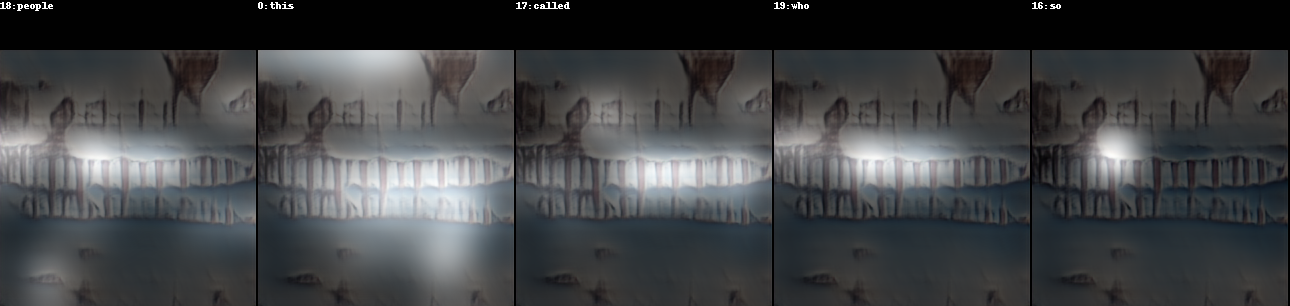

Shape: 1290 x 306


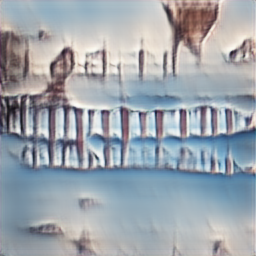

Shape: 256 x 256


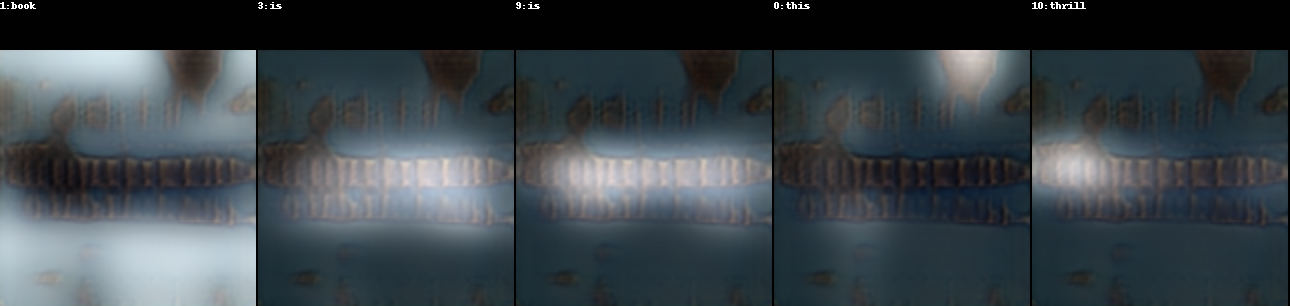

Shape: 1290 x 306


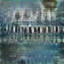

Shape: 64 x 64


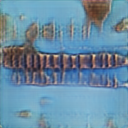

Shape: 128 x 128


In [43]:
from PIL import Image
import os

folder_path = '/kaggle/working/output'
files = os.listdir(folder_path)
for file in files:
    if file.endswith('.png'):
        file_path = os.path.join(folder_path, file)
        with Image.open(file_path) as img:
            width, height = img.size
            display(img)
            print('Shape:', width, 'x', height)

In [44]:
!pip install telebot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 6.5 MB/s eta 0:00:00:00:01


In [45]:
import telebot
from telebot import types
import subprocess
import os


TOKEN = ''
bot = telebot.TeleBot(TOKEN)


def generate_images(user_info):
#     full_path = f'../../Images/{user_info["id"]}'
    full_path = f'/kaggle/working/Images/{user_info["id"]}'
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    prompt = f'This book title is {user_info["title"]} .\n' \
             f'This book Genres is {user_info["genres"].lower()} .\n' \
             f'{user_info["annotation"].lower()}'

    command = [
        "python",
        "main.py",
        "--cfg",
        "cfg/eval_books.yml",
        "--gpu",
        "1",
        "--input_text",
        prompt,
        "--output_dir",
        full_path
    ]

    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if result.returncode == 0:
        markup = types.ReplyKeyboardMarkup(one_time_keyboard=True)
        itembtn = types.KeyboardButton('Create book cover')
        markup.add(itembtn)
        bot.send_message(user_info["id"], f"Book cover generated successfully!", reply_markup=markup)
        with open(full_path + '/0_s_0_g2.png', 'rb') as photo:
            bot.send_photo(user_info["id"], photo)
    else:
        error = result.stderr.decode("utf-8")
        print("Ошибка выполнения команды: {error}")
        bot.send_message(user_info["id"], f"Ooops... something went wrong: {error}")


@bot.message_handler(func=lambda message: message.text == 'Create book cover')
def start_message(message):
    markup = types.ReplyKeyboardRemove()
    bot.send_message(message.chat.id, 'Send a message with book title', reply_markup=markup)
    user_info = {'id': message.chat.id}
    bot.register_next_step_handler(message, get_title, user_info)


def get_title(message, user_info):
    user_info['title'] = message.text
    bot.send_message(message.chat.id, 'Send a message with genres separated with commas\n'
                                      'Example:  '
                                      'mystery, fantasy, thriller')
    bot.register_next_step_handler(message, get_genres, user_info)


def get_genres(message, user_info):
    user_info['genres'] = message.text
    bot.send_message(message.chat.id, 'Send a message with annotation')
    bot.register_next_step_handler(message, get_annotation, user_info)


def get_annotation(message, user_info):
    user_info['annotation'] = message.text
    bot.send_message(message.chat.id, 'We are starting generation... The process may take a long time!')
    generate_images(user_info)


@bot.message_handler(commands=['start'])
def send_welcome(message):
    markup = types.ReplyKeyboardMarkup(one_time_keyboard=True)
    itembtn = types.KeyboardButton('Create book cover')
    markup.add(itembtn)
    bot.send_message(message.chat.id, "Hello!\n This bot is made for book covers creations\nPress the button to start generation", reply_markup=markup)

@bot.message_handler(commands=['help'])
def send_help(message):
    help_text = "This bot is designed to generate book covers based on user input.\n\n" \
                "To start, simply type 'Create book cover' or use command \start and press the button. The bot will then guide you through providing the necessary information: book title, genres, and annotation.\n\n" \
                "Please, do not use 'Create book cover' unless previous one is not generated \n" \
                "Here are some commands you can use:\n" \
                "/start - Start the bot\n" \
                "/help - Display this help message"
    bot.send_message(message.chat.id, help_text)


bot.polling()


In [57]:
# !python main.py --cfg cfg/eval_coco.yml --gpu 1 --input_text "A book cover, Title is Walk the Vanished Earth" --output_dir output
# from IPython.display import Image, display
# import os
# folder_path = '/kaggle/working/AttnGAN/code/output'
# files = os.listdir(folder_path)
# for file in files:
#     if file.endswith('.png'):
#         display(Image(filename=os.path.join(folder_path, file)))